In [3]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

In [4]:
data_dir = "/kaggle/working/dogs-vs-cats"
if not os.path.exists(data_dir):
    with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as zip_ref:
        zip_ref.extractall(data_dir)


In [5]:
all_images = os.listdir(data_dir + '/train')
all_images = [img for img in all_images if img.endswith('.jpg')]

labels = [1 if 'dog' in img else 0 for img in all_images]  # dog=1, cat=0
image_paths = [os.path.join(data_dir, 'train', img) for img in all_images]

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)


In [6]:
class DogCatDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = DogCatDataset(train_paths, train_labels, transform=transform)
val_dataset = DogCatDataset(val_paths, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [14]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 41.8253
Epoch 2/10, Loss: 11.8831
Epoch 3/10, Loss: 9.5424
Epoch 4/10, Loss: 8.7176
Epoch 5/10, Loss: 7.0090
Epoch 6/10, Loss: 5.3468
Epoch 7/10, Loss: 7.0167
Epoch 8/10, Loss: 4.2267
Epoch 9/10, Loss: 3.5308
Epoch 10/10, Loss: 4.4853


In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 97.74%


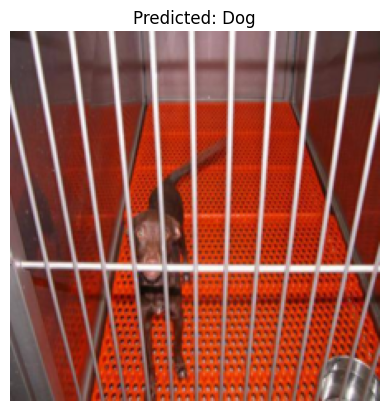

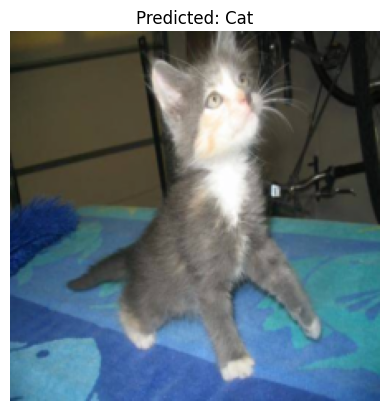

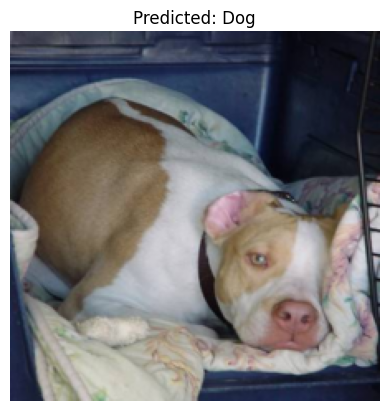

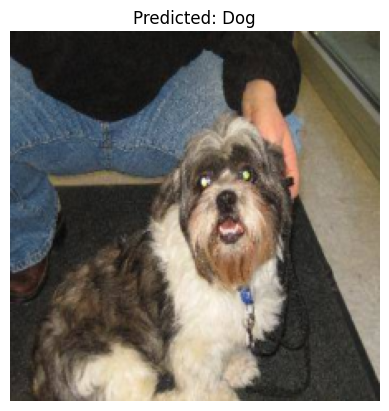

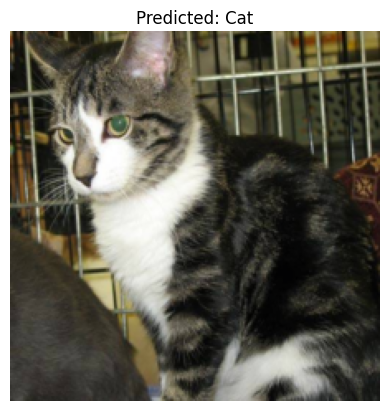

In [16]:
def show_predictions(loader, model, num=5):
    model.eval()
    count = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(images)):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f"Predicted: {'Dog' if predicted[i]==1 else 'Cat'}")
                plt.axis('off')
                plt.show()

                count += 1
                if count == num:
                    return

show_predictions(val_loader, model, num=5)
